<a href="https://colab.research.google.com/github/alwanfa/neural-network-exploration/blob/main/datasize_modelsize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [2]:
def createData(nPerClust) :
  A = [1,1]
  B = [5,1]
  C = [4,4]

  a = [A[0]+np.random.randn(nPerClust), A[1]+np.random.randn(nPerClust)]
  b = [B[0]+np.random.randn(nPerClust), B[1]+np.random.randn(nPerClust)]
  c = [C[0]+np.random.randn(nPerClust), C[1]+np.random.randn(nPerClust)]

  labels_np = np.hstack((np.zeros(nPerClust), np.ones(nPerClust), 1+np.ones(nPerClust)))

  data_np = np.hstack((a,b,c)).T

  output = {}
  output['data'] = torch.tensor(data_np).float()
  output['label']= torch.tensor(labels_np).long()

  X_train, X_test, y_train , y_test = train_test_split(output['data'], output['label'], test_size = .2)

  train_dataset = TensorDataset(X_train, y_train)
  test_dataset = TensorDataset(X_test, y_test)

  batchsize = 8

  output['train_loader'] = DataLoader(train_dataset, batch_size = batchsize, shuffle = True, drop_last = True)
  output['test_loader'] = DataLoader(test_dataset, batch_size = test_dataset.tensors[0].shape[0])

  return output

In [3]:
data = createData(100)

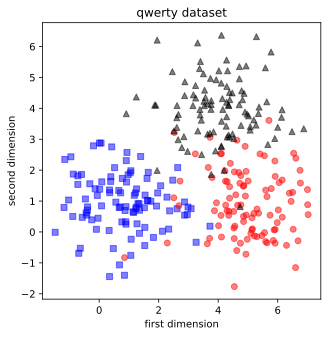

In [5]:
fig = plt.figure(figsize = (5,5))

X = data['data']
y = data['label']
plt.plot(X[np.where(y == 0)[0],0],X[np.where(y == 0)[0],1], 'bs', alpha = 0.5)
plt.plot(X[np.where(y == 1)[0],0],X[np.where(y == 1)[0],1], 'ro', alpha = 0.5)
plt.plot(X[np.where(y == 2)[0],0],X[np.where(y == 2)[0],1], 'k^', alpha = 0.5)

plt.xlabel('first dimension')
plt.ylabel('second dimension')
plt.title('qwerty dataset')
plt.show()

In [6]:
def qwertyCustomableModel(num_layers, num_hiddens) :
  class qwertyNet(nn.Module) :
    def __init__(self, num_layers = 1, num_hiddens = 50) :
      super().__init__()

      self.layers = nn.ModuleDict()
      self.num_layers = num_layers


      self.layers['input'] = nn.Linear(2,num_hiddens)

      for i in range(self.num_layers) :
        self.layers[f'hidden{i}'] = nn.Linear(num_hiddens, num_hiddens)

      self.layers['output'] = nn.Linear(num_hiddens,3)

    def forward(self, x) :
      x = self.layers['input'](x)

      for i in range(self.num_layers) :
        x = F.relu(self.layers[f'hidden{i}'](x))

      x = self.layers['output'](x)

      return x

  net = qwertyNet(num_layers, num_hiddens)

  lossfun = nn.CrossEntropyLoss()

  optimizer = torch.optim.SGD(net.parameters(), lr = .01)

  return net, lossfun, optimizer

In [7]:
num_layers = 4
num_unit_per_layer = 12

net, lossf, opt = qwertyCustomableModel(num_layers, num_unit_per_layer)
print(net)

input = torch.rand(10,2)
net(input)

qwertyNet(
  (layers): ModuleDict(
    (input): Linear(in_features=2, out_features=12, bias=True)
    (hidden0): Linear(in_features=12, out_features=12, bias=True)
    (hidden1): Linear(in_features=12, out_features=12, bias=True)
    (hidden2): Linear(in_features=12, out_features=12, bias=True)
    (hidden3): Linear(in_features=12, out_features=12, bias=True)
    (output): Linear(in_features=12, out_features=3, bias=True)
  )
)


tensor([[-0.1370, -0.1845,  0.2127],
        [-0.1363, -0.1890,  0.2122],
        [-0.1343, -0.1944,  0.2111],
        [-0.1407, -0.1789,  0.2147],
        [-0.1345, -0.1930,  0.2112],
        [-0.1354, -0.1925,  0.2117],
        [-0.1401, -0.1804,  0.2143],
        [-0.1348, -0.1922,  0.2114],
        [-0.1414, -0.1766,  0.2151],
        [-0.1356, -0.1921,  0.2118]], grad_fn=<AddmmBackward0>)

In [8]:
def trainModel(num_layer = 1, num_hidden = 50) :
  epoch = 50
  net, lossfun, optimizer = qwertyCustomableModel(num_layer, num_hidden)
  trainlosses = torch.zeros(epoch)
  testlosses = torch.zeros(epoch)
  trainAcc = []
  testAcc = []


  for epochi in range(epoch) :
    batchAcc = []
    batchLoss = []

    for X,y in data['train_loader']:
      yHat = net(X)
      loss = lossfun(yHat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())
      matches = torch.argmax(yHat, axis = 1) == y
      matchesNumeric = matches.float()
      accuracyPercent = 100 * torch.mean(matchesNumeric)
      batchAcc.append(accuracyPercent)

    trainAcc.append(np.mean(batchAcc))
    trainlosses[epochi] = np.mean(batchLoss)

    X,y = next(iter(data['test_loader']))
    yHat = net(X)

    testAcc.append(100*torch.mean((torch.argmax(yHat, axis = 1)==y).float()))
    testlosses[epochi] = lossfun(yHat,y).item()

  return trainAcc, testAcc, trainlosses, testlosses, net

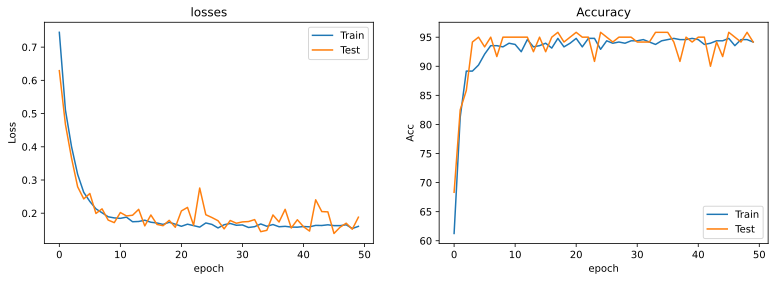

In [9]:
data = createData(200)
trainAcc, testAcc, trainlosses, testlosses, net = trainModel(1,80)

fig, ax = plt.subplots(1,2, figsize = (13,4))

ax[0].plot(trainlosses.detach(), label = "Train")
ax[0].plot(testlosses.detach(), label = "Test")
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('losses')
ax[0].legend()

ax[1].plot(trainAcc, label = "Train")
ax[1].plot(testAcc, label = "Test")
ax[1].set_ylabel('Acc')
ax[1].set_xlabel('epoch')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

In [10]:
nNodesInModel = 80
layersRange = [1,5,10,20]
nDataPoints = np.arange(50,551,50)
legend = []

for lidx, layers in enumerate(layersRange) :
  unitsPerLayer  = int(nNodesInModel/layersRange[lidx])
  net = qwertyCustomableModel(layers, unitsPerLayer)[0]
  nparams = np.sum([p.numel() for p in net.parameters() if p.requires_grad])

  legend.append(f'{layers} layers, {unitsPerLayer} unit, {nparams} params')



In [11]:
legend

['1 layers, 80 unit, 6963 params',
 '5 layers, 16 unit, 1459 params',
 '10 layers, 8 unit, 771 params',
 '20 layers, 4 unit, 427 params']

In [12]:
results = np.zeros((len(nDataPoints), len(layersRange),2))


for didx, pnts in enumerate(nDataPoints) :
  data = createData(pnts)
  trainData = data["train_loader"]
  testData = data["test_loader"]

  for lidx,layers in enumerate(layersRange) :
    unitsLayer = int(nNodesInModel/layersRange[lidx])
    trainAcc, testAcc, trainLosses, testLosses, net = trainModel(layers, unitsLayer)

    results[didx, lidx, 0] = np.mean(testAcc[-5:])
    results[didx, lidx, 1] = torch.mean(trainLosses[-5:]).item()

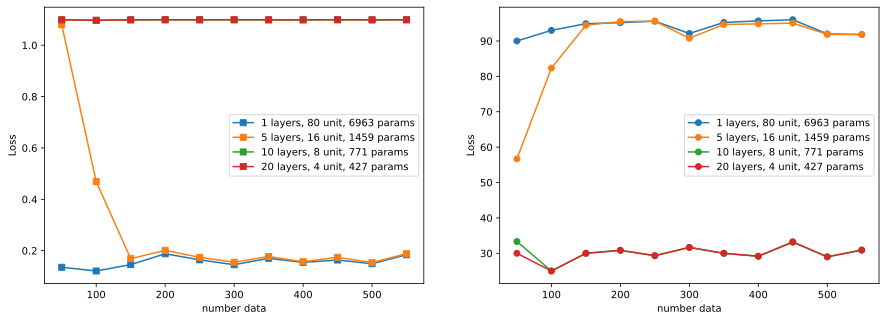

In [13]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

ax[0].plot(nDataPoints, results[:,:,1], 's-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('number data')
ax[0].legend(legend)

ax[1].plot(nDataPoints, results[:,:,0], 'o-')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('number data')
ax[1].legend(legend)
plt.show()